# Package Installation and Environment Setup
This cell imports all necessary Python libraries that are used throughout the notebook. It includes packages for:
- Data manipulation (pandas, numpy)
- Financial data acquisition (yfinance)
- Statistical analysis (scipy.stats, sklearn)
- Data visualization (matplotlib, seaborn)
- Utility functions for date/time management (datetime, pathlib)
- Additional utilities (typing, json, requests)

The cell also sets display options for pandas to ensure clear and complete output, and suppresses non-critical warnings for a cleaner interface.

In [11]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Financial data
import yfinance as yf

# Date handling
from datetime import datetime, timedelta, date
from pathlib import Path

# Statistical analysis

import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data types and utilities
from typing import Dict, List, Optional, Tuple
import json
import requests

# Set pandas display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("All packages imported successfully!")
print("Ready for Four-Factor Model implementation")


All packages imported successfully!
Ready for Four-Factor Model implementation


# Definition of the FourFactorModel Class
This cell defines the core class FourFactorModel, which encapsulates the entire methodology needed to reconstruct the Indian four-factor asset pricing model. The class includes functionality to:

- Download stock price and metadata for given NSE symbols
- Calculate company market capitalization, book-to-market ratios, and momentum scores
- Form portfolios based on size-value and size-momentum breakpoints
- Compute daily factor returns for Market Risk Premium (MRP), Size (SMB), Value (HML), and Momentum (WML)
- Output a tidy DataFrame with factor returns ready for further analysis

In [12]:
class FourFactorModel:
    """
    Four‐Factor Model for Indian equities using Yahoo Finance data.
 Factors: Market Risk Premium (MRP), SMB (Size), HML (Value), WML (Momentum).
    """

    def __init__(self,
                 start_date: str = "2018-01-01",
                 end_date: str | None = None,
                 rf_annual_rate: float = 0.06):
        import pandas as pd
        import numpy as np

        self.pd = pd
        self.np = np
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date) if end_date else pd.Timestamp.now()
        self.rf_daily = rf_annual_rate / 252
        self.price_data: dict[str, pd.DataFrame] = {}
        self.info_data: dict[str, dict] = {}
        self.portfolio_members: dict[str, list[str]] = {}
        self.portfolio_weights: dict[str, dict[str, float]] = {}
        self.factor_returns: pd.DataFrame | None = None

    def fetch_prices(self, symbols: list[str]) -> None:
        """
        Download historical OHLCV for each symbol from Yahoo Finance.
        Stores DataFrame per symbol in self.price_data and info in self.info_data.
        """
        import yfinance as yf

        for sym in symbols:
            ticker = yf.Ticker(f"{sym}.NS")
            hist = ticker.history(start=self.start_date, end=self.end_date)
            if not hist.empty:
                self.price_data[sym] = hist[['Open', 'High', 'Low', 'Close', 'Volume']]
                self.info_data[sym] = ticker.info

    def _calc_market_cap(self, sym: str) -> float:
        """
        Compute market cap using 'marketCap' or fallback to sharesOutstanding × last Close.
        """
        info = self.info_data[sym]
        if info.get('marketCap'):
            return info['marketCap']
        so = info.get('sharesOutstanding') or info.get('impliedSharesOutstanding')
        if so:
            return so * self.price_data[sym]['Close'].iloc[-1]
        avg_close = self.price_data[sym]['Close'].mean()
        return avg_close * 1e8

    def _calc_book_to_market(self, sym: str) -> float:
        """
        Compute book-to-market ratio from yahoo 'bookValue' or priceToBook.
        """
        info = self.info_data[sym]
        bv = info.get('bookValue')
        if bv:
            return bv / self.price_data[sym]['Close'].iloc[-1]
        pb = info.get('priceToBook')
        cp = info.get('currentPrice')
        if pb and cp:
            return (cp / pb) / self.price_data[sym]['Close'].iloc[-1]
        return 0.0

    def _calc_momentum(self, sym: str) -> float:
        """
        11-month momentum = (price t-1 / price t-12) – 1.
        """
        closes = self.price_data[sym]['Close']
        if len(closes) < 252:
            return 0.0
        p12 = closes.iloc[-252]
        p1 = closes.iloc[-21]
        return (p1 / p12) - 1 if p12 > 0 else 0.0

    def form_portfolios(self) -> None:
        """
        Form value-weighted size-value and size-momentum portfolios as of the latest month-end.
        """
        # 1. Compute characteristics
        caps = {s: self._calc_market_cap(s) for s in self.price_data}
        bms = {s: self._calc_book_to_market(s) for s in self.price_data}
        moms = {s: self._calc_momentum(s) for s in self.price_data}

        # 2. Breakpoints
        cap90 = self.np.percentile(list(caps.values()), 90)
        bm30, bm70 = self.np.percentile(list(bms.values()), [30, 70])
        mom30, mom70 = self.np.percentile(list(moms.values()), [30, 70])

        # 3. Classify into groups
        small = [s for s, c in caps.items() if c <= cap90]
        big = [s for s, c in caps.items() if c > cap90]
        value = [s for s, b in bms.items() if b >= bm70]
        neutral = [s for s, b in bms.items() if bm30 < b < bm70]
        growth = [s for s, b in bms.items() if b <= bm30]
        winners = [s for s, m in moms.items() if m >= mom70]
        losers = [s for s, m in moms.items() if m <= mom30]

        # 4. Build portfolios
        year = self.end_date.year
        tag = f"{year}_"
        portfolios = {
            tag + 'SV': [s for s in small if s in value],
            tag + 'SN': [s for s in small if s in neutral],
            tag + 'SG': [s for s in small if s in growth],
            tag + 'BV': [s for s in big if s in value],
            tag + 'BN': [s for s in big if s in neutral],
            tag + 'BG': [s for s in big if s in growth],
            tag + 'WS': [s for s in winners if s in small],
            tag + 'WB': [s for s in winners if s in big],
            tag + 'LS': [s for s in losers if s in small],
            tag + 'LB': [s for s in losers if s in big],
        }

        # 5. Compute value weights at formation
        weights = {}
        for p, members in portfolios.items():
            total_cap = sum(caps[s] for s in members) or 1.0
            weights[p] = {s: caps[s] / total_cap for s in members}

        # 6. Store portfolios and weights
        self.portfolio_members = portfolios
        self.portfolio_weights = weights

    def calculate_factors_value_weighted(self) -> pd.DataFrame:
        """
        Compute daily factor returns using value-weighted portfolio returns.
        """
        # Align dates
        all_dates = None
        closes = {s: df['Close'] for s, df in self.price_data.items()}
        for series in closes.values():
            all_dates = series.index if all_dates is None else all_dates.intersection(series.index)

        returns = self.pd.DataFrame({
            s: closes[s].pct_change().fillna(0).reindex(all_dates)
            for s in closes
        }).loc[all_dates]

        # Portfolio returns (value-weighted)
        port_rets = {}
        for p, members in self.portfolio_members.items():
            w = self.portfolio_weights[p]
            port_rets[p] = sum(returns[s] * w.get(s, 0) for s in members)

        pr = self.pd.DataFrame(port_rets)
        t = f"{self.end_date.year}_"

        # Factor definitions
        SMB = (pr[t + 'SV'] + pr[t + 'SN'] + pr[t + 'SG']) / 3 - (pr[t + 'BV'] + pr[t + 'BN'] + pr[t + 'BG']) / 3
        HML = (pr[t + 'SV'] + pr[t + 'BV']) / 2 - (pr[t + 'SG'] + pr[t + 'BG']) / 2
        WML = (pr[t + 'WS'] + pr[t + 'WB']) / 2 - (pr[t + 'LS'] + pr[t + 'LB']) / 2

        # Market and risk-free
        total_caps = {s: self._calc_market_cap(s) for s in returns.columns}
        mkt = sum(returns[s] * total_caps[s] for s in returns.columns)
        mkt = mkt / sum(total_caps.values())
        rf = self.pd.Series(self.rf_daily, index=all_dates)
        MRP = mkt - rf

        # Combine factors
        df = self.pd.DataFrame({
            'MKT': mkt,
            'RF': rf,
            'MRP': MRP,
            'SMB': SMB,
            'HML': HML,
            'WML': WML
        }).fillna(0)

        self.factor_returns = df
        return df

    def factor_statistics(self) -> pd.DataFrame:
        """
        Return annualized mean, volatility, Sharpe, min/max for each factor.
        """
        df = self.factor_returns.copy()
        stats = {
            'Mean%': df.mean() * 252 * 100,
            'Vol%': df.std() * (252**0.5) * 100,
            'Sharpe': (df.mean() * 252) / (df.std() * (252**0.5)),
            'Min%': df.min() * 100,
            'Max%': df.max() * 100
        }
        return self.pd.DataFrame(stats).round(2)


# Configuration and Stock Universe Specification
Here, the analysis parameters are set:
- The analysis period is defined by the start and end dates
- A list of NSE-listed stock tickers (without the .NS suffix) is specified as the stock universe
- An instance of FourFactorModel is created with these parameters and an assumed annual risk-free rate of 6%
- A summary of the configuration, including the date range and universe size, is printed for verification

In [13]:
# 1. Set analysis period
START_DATE = "2020-01-01"
END_DATE   ="2025-06-30"

# 2. Define your Indian stock universe (NSE symbols, no “.NS” suffix)
indian_stocks = [
    "RELIANCE", "TCS", "INFY", "HDFCBANK", "ITC",
    "HINDUNILVR", "ICICIBANK", "KOTAKBANK", "BHARTIARTL",
    "SBIN", "ASIANPAINT", "LT", "AXISBANK", "MARUTI",
    "BAJFINANCE"
]

# 3. Instantiate the model
model = FourFactorModel(
    start_date = START_DATE,
    end_date   = END_DATE,
    rf_annual_rate = 0.06    # 6% annual risk-free assumption
)

# 4. Display configuration summary
print(f"Analysis period: {START_DATE} to {END_DATE}")
print(f"Universe size   : {len(indian_stocks)} stocks")
print("Stocks           :", indian_stocks)


Analysis period: 2020-01-01 to 2025-06-30
Universe size   : 15 stocks
Stocks           : ['RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ITC', 'HINDUNILVR', 'ICICIBANK', 'KOTAKBANK', 'BHARTIARTL', 'SBIN', 'ASIANPAINT', 'LT', 'AXISBANK', 'MARUTI', 'BAJFINANCE']


# Data Acquisition and Preprocessing
This cell performs data collection and preparation:
- Downloads historical price and fundamental data for each stock from Yahoo Finance
- Summarizes data availability for each stock
- Applies a liquidity filter to exclude stocks with fewer than 50 trading days in the past year, ensuring portfolios are formed from investible stocks
- Plots closing price histories of the filtered stocks to check for anomalies or outliers

Fetching price and info data for each stock...

Data loaded summary:
  RELIANCE: 1360 rows from 2020-01-01 to 2025-06-27
  TCS: 1360 rows from 2020-01-01 to 2025-06-27
  INFY: 1360 rows from 2020-01-01 to 2025-06-27
  HDFCBANK: 1360 rows from 2020-01-01 to 2025-06-27
  ITC: 1360 rows from 2020-01-01 to 2025-06-27
  HINDUNILVR: 1360 rows from 2020-01-01 to 2025-06-27
  ICICIBANK: 1360 rows from 2020-01-01 to 2025-06-27
  KOTAKBANK: 1360 rows from 2020-01-01 to 2025-06-27
  BHARTIARTL: 1360 rows from 2020-01-01 to 2025-06-27
  SBIN: 1360 rows from 2020-01-01 to 2025-06-27
  ASIANPAINT: 1360 rows from 2020-01-01 to 2025-06-27
  LT: 1360 rows from 2020-01-01 to 2025-06-27
  AXISBANK: 1360 rows from 2020-01-01 to 2025-06-27
  MARUTI: 1360 rows from 2020-01-01 to 2025-06-27
  BAJFINANCE: 1360 rows from 2020-01-01 to 2025-06-27

Stocks passing liquidity filter (15): ['RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ITC', 'HINDUNILVR', 'ICICIBANK', 'KOTAKBANK', 'BHARTIARTL', 'SBIN', 'ASIANPAINT', 'LT',

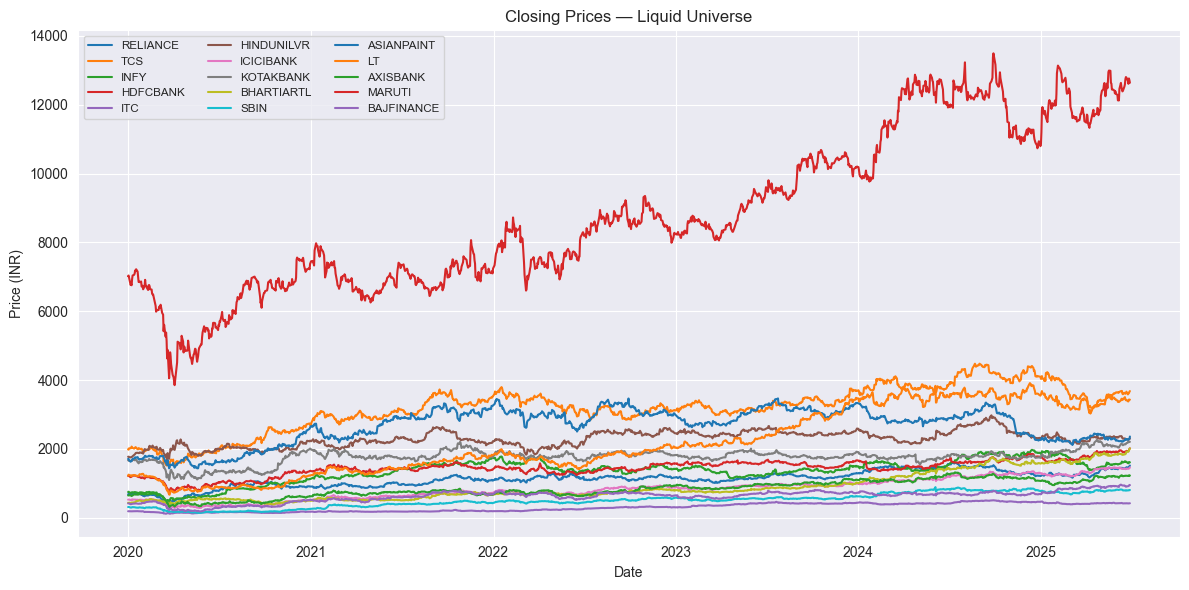

In [14]:
# 1. Fetch historical price & info data
print("Fetching price and info data for each stock...")
model.fetch_prices(indian_stocks)

# 2. Verify data loaded
print("\nData loaded summary:")
for sym in indian_stocks:
    if sym in model.price_data:
        df = model.price_data[sym]
        print(f"  {sym}: {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")
    else:
        print(f"  {sym}:  No data")

# 3. Apply liquidity filter
#    Keep stocks trading at least 50 days per year over the past 1 year
def liquidity_filter(price_dict, min_days=50, lookback_days=252):
    filtered = []
    for sym, df in price_dict.items():
        recent = df['Close'].iloc[-lookback_days:]
        trading_days = recent.dropna().shape[0]
        if trading_days >= min_days:
            filtered.append(sym)
    return filtered

liquid_universe = liquidity_filter(model.price_data, min_days=50)
print(f"\nStocks passing liquidity filter ({len(liquid_universe)}): {liquid_universe}")

# 4. Narrow down to liquid subset for portfolio formation
indian_stocks = liquid_universe.copy()
print(f"\nUniverse for portfolios: {indian_stocks}")

# 5. Plot closing price history for visual inspection
plt.figure(figsize=(12,6))
for sym in indian_stocks:
    plt.plot(model.price_data[sym]['Close'], label=sym)
plt.title("Closing Prices — Liquid Universe")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
plt.show()


# Portfolio Formation and Factor Computation
In this cell:
- Size-value and size-momentum portfolios are constructed according to the breakpoints defined in the research
- Daily returns of portfolios are calculated and combined to derive the four factor return time series (MRP, SMB, HML, WML)
- Results are previewed and saved as a CSV file for further use

Forming value-weighted portfolios...

Portfolio membership summary:
  2025_SV: 3 stocks
  2025_SN: 5 stocks
  2025_SG: 5 stocks
  2025_BV: 2 stocks
  2025_BN: 0 stocks
  2025_BG: 0 stocks
  2025_WS: 4 stocks
  2025_WB: 1 stocks
  2025_LS: 4 stocks
  2025_LB: 1 stocks

Calculating value-weighted factor returns...

Factor returns (head):


,MKT,RF,MRP,SMB,HML,WML
Date,,,,,,
2020-01-01 00:00:00+05:30,0.000000,0.000238,-0.000238,0.000000,0.000000,0.000000
2020-01-02 00:00:00+05:30,0.006988,0.000238,0.006750,0.001737,0.011179,-0.002859
2020-01-03 00:00:00+05:30,-0.003042,0.000238,-0.003281,-0.003230,-0.013450,-0.011954
2020-01-06 00:00:00+05:30,-0.019318,0.000238,-0.019557,-0.013154,-0.021577,-0.005679
2020-01-07 00:00:00+05:30,0.003743,0.000238,0.003505,-0.005535,0.011233,-0.003259



Factor returns saved to four_factor_returns_value_weighted.csv


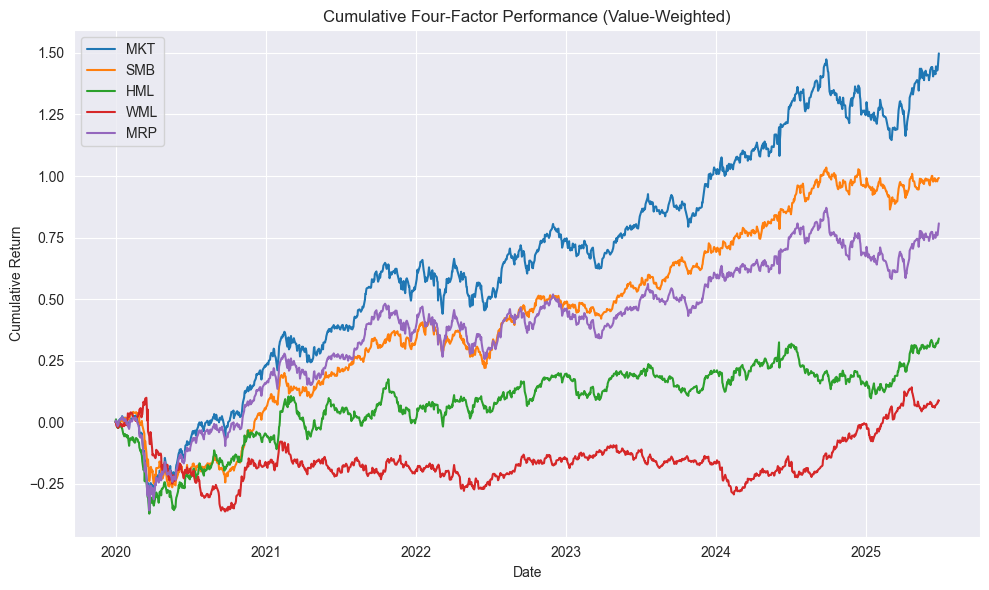

In [15]:
# 1. Form value-weighted portfolios based on size, value, and momentum
print("Forming value-weighted portfolios...")
model.form_portfolios()  # This should save portfolio weights internally

# 2. Display portfolio membership counts
print("\nPortfolio membership summary:")
for name, members in model.portfolio_members.items():
    print(f"  {name}: {len(members)} stocks")

# 3. Calculate daily value-weighted factor returns
print("\nCalculating value-weighted factor returns...")
factors_df = model.calculate_factors_value_weighted()

# 4. Preview the first few rows of the factor DataFrame
print("\nFactor returns (head):")
display(factors_df.head())

# 5. Save factor returns to CSV for downstream analysis
csv_path = Path("four_factor_returns_value_weighted.csv")
factors_df.to_csv(csv_path, index=True)
print(f"\nFactor returns saved to {csv_path}")

# 6. Plot cumulative factor performance
cum_returns = (1 + factors_df[['MKT','SMB','HML','WML','MRP']]).cumprod() - 1

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for col in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[col], label=col)
plt.title("Cumulative Four-Factor Performance (Value-Weighted)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


# Factor Performance Summary and Correlation Analysis
This cell:
- Computes annualized summary statistics (mean returns, volatility, Sharpe ratios, minimum and maximum returns) for each factor
- Calculates the correlation matrix between the factors and visualizes it as a heatmap and pairplot to examine their relationships and independence

Computing factor performance statistics

Annualized Factor Statistics (%):


,Mean%,Vol%,Sharpe,Min%,Max%
MKT,18.82,19.17,9.800000e-01,-13.53,9.55
RF,6.00,0.00,6.969650e+16,0.02,0.02
MRP,12.82,19.17,6.700000e-01,-13.56,9.53
SMB,13.97,15.41,9.100000e-01,-10.37,5.10
HML,7.33,19.50,3.800000e-01,-9.95,8.18
WML,3.42,19.37,1.800000e-01,-8.48,8.31



Calculating inter-factor correlations...

Factor Correlation Matrix:


,MKT,SMB,HML,WML,MRP
MKT,1.000000,0.803687,0.741273,0.110046,1.000000
SMB,0.803687,1.000000,0.528269,0.294591,0.803687
HML,0.741273,0.528269,1.000000,0.195636,0.741273
WML,0.110046,0.294591,0.195636,1.000000,0.110046
MRP,1.000000,0.803687,0.741273,0.110046,1.000000


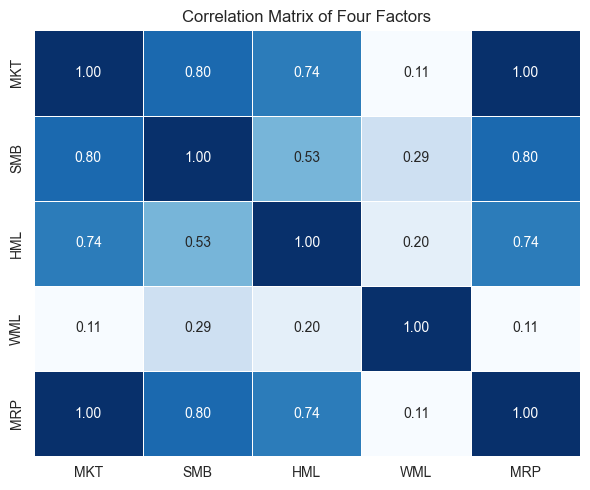


Generating pairplot of daily factor returns (first 500 days)...


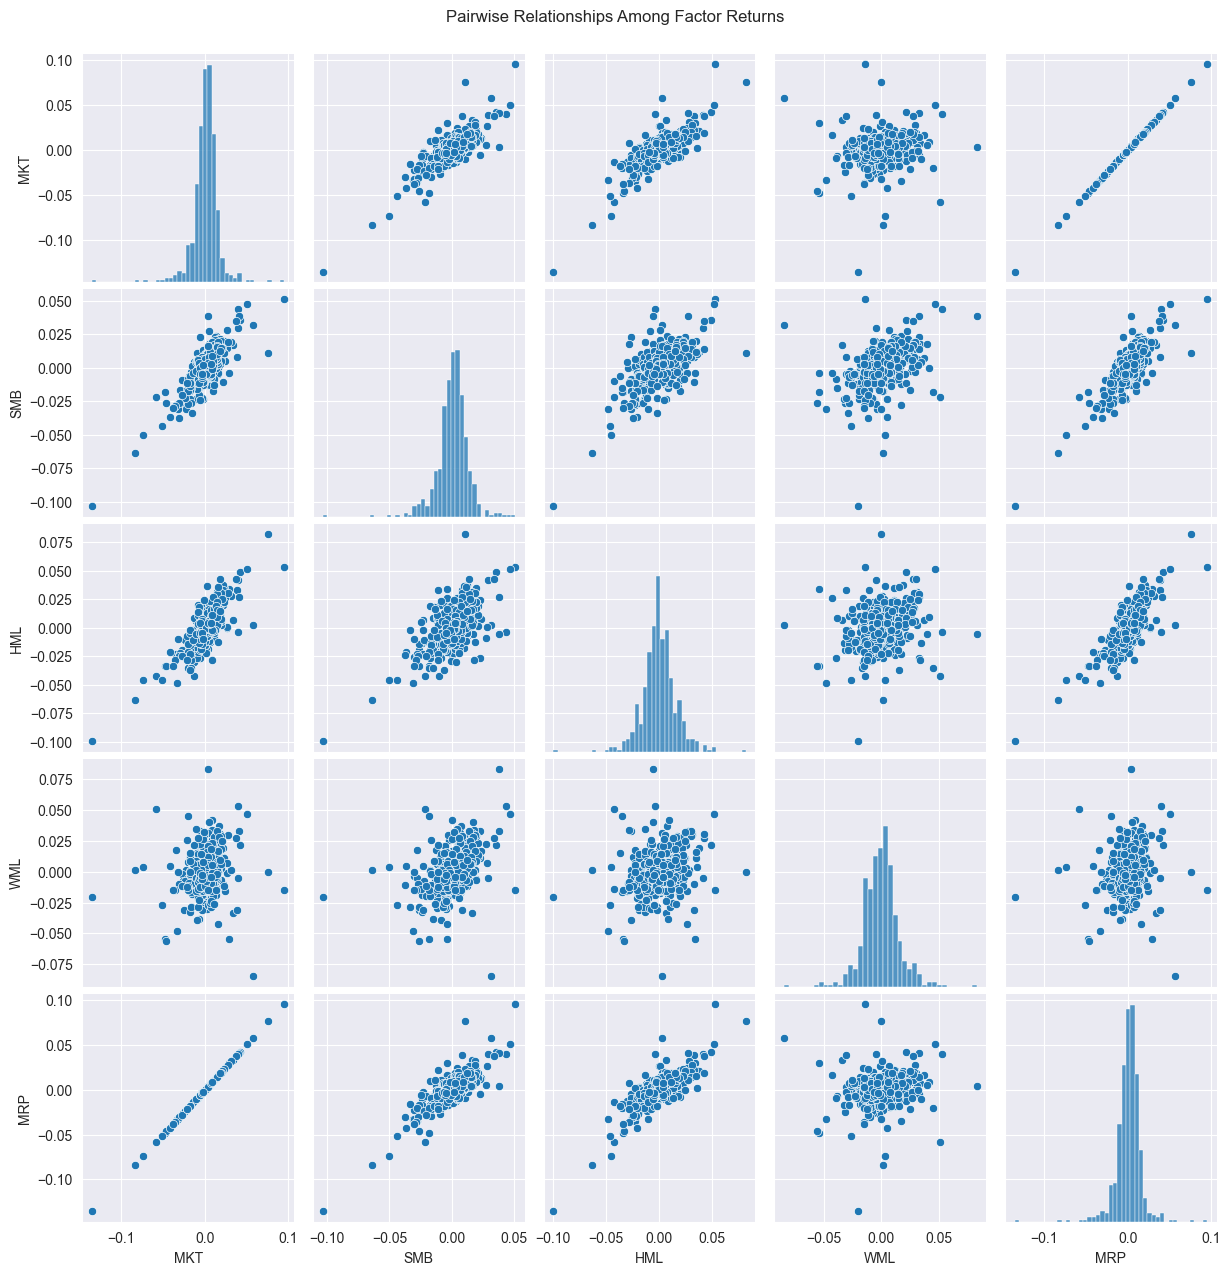

In [16]:
# 1. Compute and display annualized statistics for each factor
print("Computing factor performance statistics")
stats_df = model.factor_statistics()
print("\nAnnualized Factor Statistics (%):")
display(stats_df)

# 2. Correlation matrix of factor returns
print("\nCalculating inter-factor correlations...")
corr_df = model.factor_returns[['MKT','SMB','HML','WML','MRP']].corr()
print("\nFactor Correlation Matrix:")
display(corr_df)

# 3. Visualize correlation heatmap

plt.figure(figsize=(6,5))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            linewidths=0.5, linecolor='white')
plt.title("Correlation Matrix of Four Factors")
plt.tight_layout()
plt.show()

# 4. Pairplot of factor returns
print("\nGenerating pairplot of daily factor returns (first 500 days)...")
sample = model.factor_returns[['MKT','SMB','HML','WML','MRP']].iloc[:500]
sns.pairplot(sample)
plt.suptitle("Pairwise Relationships Among Factor Returns", y=1.02)
plt.show()


# Results Export and Visualization of Factor Dynamics
Here:
- Factor return series and their statistics are saved to CSV files
- Time series plots of daily factor returns and rolling six-month volatilities are generated to visualize factor behavior and stability

Saving factor returns and statistics CSV files...
Saved:
   - four_factor_returns.csv
   - factor_statistics.csv



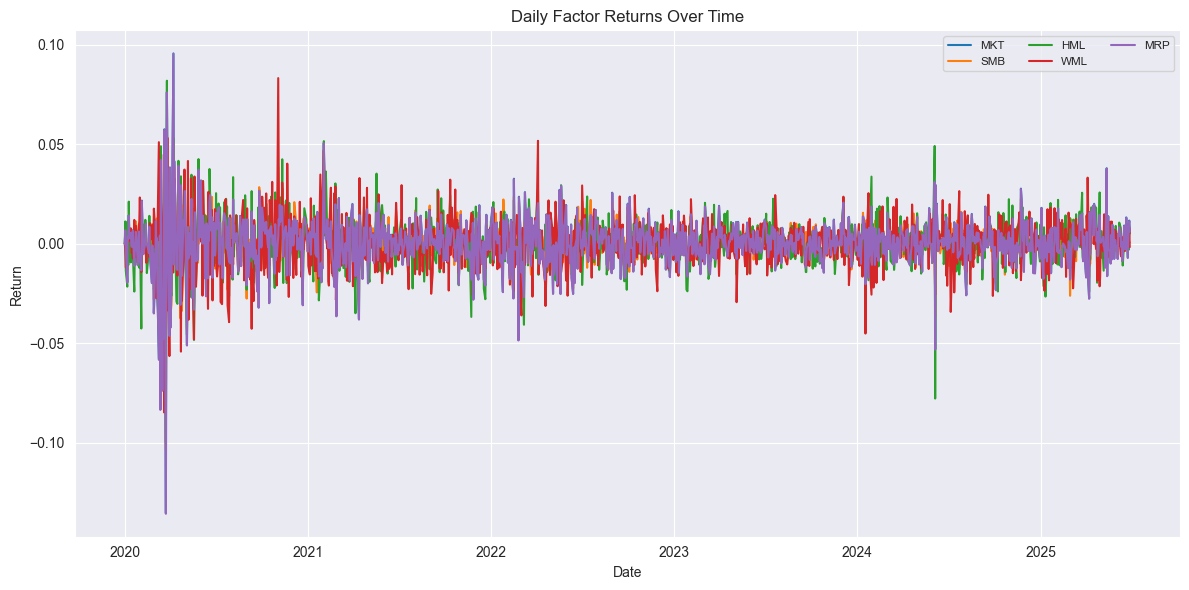

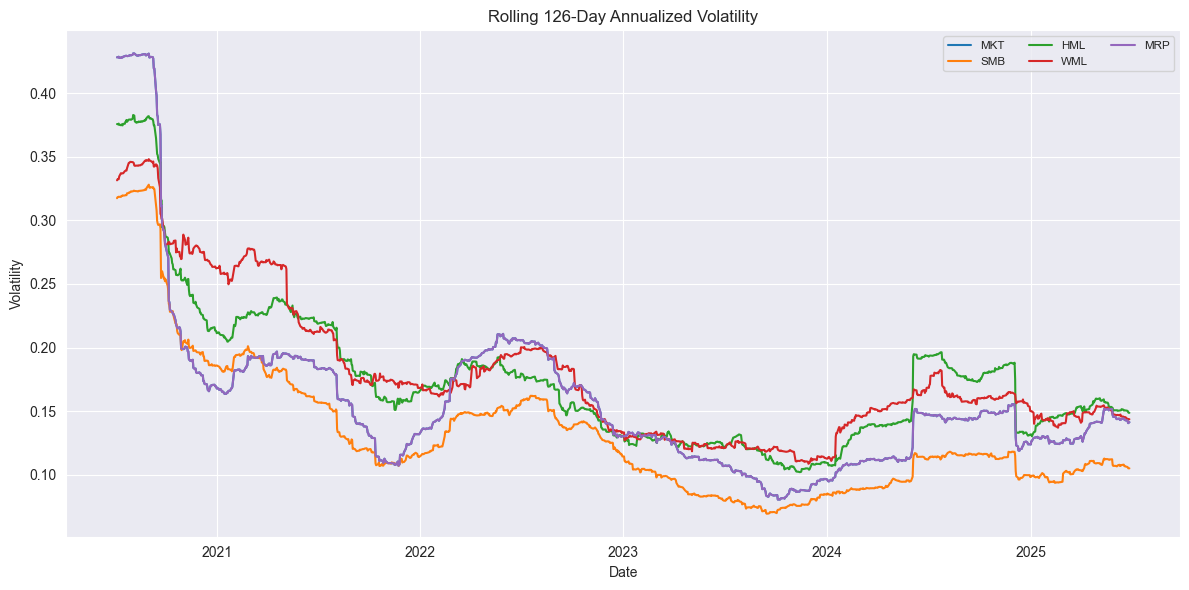


Factor returns (last 5 rows):


,MKT,RF,MRP,SMB,HML,WML
Date,,,,,,
2025-06-23 00:00:00+05:30,-0.006937,0.000238,-0.007175,-0.003580,-0.000613,0.004066
2025-06-24 00:00:00+05:30,0.001208,0.000238,0.000970,0.003076,0.005706,0.006920
2025-06-25 00:00:00+05:30,0.009273,0.000238,0.009035,0.002735,-0.003022,-0.001692
2025-06-26 00:00:00+05:30,0.011600,0.000238,0.011362,0.000583,0.007427,0.008095
2025-06-27 00:00:00+05:30,0.006267,0.000238,0.006029,0.000552,0.005204,-0.001725



Factor statistics:


,Mean%,Vol%,Sharpe,Min%,Max%
MKT,18.82,19.17,9.800000e-01,-13.53,9.55
RF,6.00,0.00,6.969650e+16,0.02,0.02
MRP,12.82,19.17,6.700000e-01,-13.56,9.53
SMB,13.97,15.41,9.100000e-01,-10.37,5.10
HML,7.33,19.50,3.800000e-01,-9.95,8.18
WML,3.42,19.37,1.800000e-01,-8.48,8.31


In [17]:
# 1. Save factor returns and statistics to CSV
print("Saving factor returns and statistics CSV files...")
model.factor_returns.to_csv("four_factor_returns.csv", index=True)
stats_df = model.factor_statistics()
stats_df.to_csv("factor_statistics.csv", index=True)
print("Saved:")
print("   - four_factor_returns.csv")
print("   - factor_statistics.csv\n")

# 2. Plot time‐series of factor returns

plt.figure(figsize=(12, 6))
for col in ['MKT', 'SMB', 'HML', 'WML', 'MRP']:
    plt.plot(model.factor_returns.index, model.factor_returns[col], label=col)
plt.title("Daily Factor Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
plt.show()

# 3. Plot rolling 6-month (126 trading days) volatility for each factor
rolling_window = 126
vol = model.factor_returns[['MKT','SMB','HML','WML','MRP']].rolling(window=rolling_window).std() * (252**0.5)

plt.figure(figsize=(12, 6))
for col in vol.columns:
    plt.plot(vol.index, vol[col], label=col)
plt.title(f"Rolling {rolling_window}-Day Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
plt.show()

# 4. Display last few rows of data
print("\nFactor returns (last 5 rows):")
display(model.factor_returns.tail())

print("\nFactor statistics:")
display(stats_df)


# Regression Analysis for Individual Stocks
This part involves:
- Regressing individual stock excess returns on the four factors to estimate factor loadings (betas) and alpha (intercepts)
- Displaying regression summaries for each stock
- Aggregating regression coefficients into a cross-sectional DataFrame and saving it for further inspection

In [18]:
# 1. Prepare the data: align each stock’s excess returns with factor returns

# Choose a target stock (e.g., RELIANCE) or loop over universe
for sym in indian_stocks:
    # Ensure we have both price data and factor returns
    if sym not in model.price_data:
        print(f"Skipping {sym}: no price data")
        continue

    # Compute daily stock returns
    stock_prices = model.price_data[sym]['Close'].reindex(model.factor_returns.index).fillna(method='ffill')
    stock_ret = stock_prices.pct_change().fillna(0)

    # Compute excess returns: stock return minus RF
    rf = model.factor_returns['RF']
    excess_ret = stock_ret - rf

    # Assemble the design matrix: constant + MRP, SMB, HML, WML
    X = model.factor_returns[['MRP', 'SMB', 'HML', 'WML']]
    X = sm.add_constant(X)

    # Align y and X
    y = excess_ret.reindex(X.index).fillna(0)

    # Run OLS regression
    ols = sm.OLS(y, X).fit()

    # Print summary
    print(f"\n===== Regression Results for {sym} =====")
    print(ols.summary().tables[1])  # coefficients table only

# 2. Collect regression statistics for all stocks into a DataFrame
results = []
for sym in indian_stocks:
    if sym not in model.price_data:
        continue
    stock_ret = model.price_data[sym]['Close'].reindex(model.factor_returns.index).pct_change().fillna(0)
    excess_ret = stock_ret - model.factor_returns['RF']
    X = sm.add_constant(model.factor_returns[['MRP', 'SMB', 'HML', 'WML']])
    y = excess_ret.reindex(X.index).fillna(0)
    ols = sm.OLS(y, X).fit()
    params = ols.params.rename(sym)
    results.append(params)

# Combine into DataFrame
regression_df = pd.concat(results, axis=1).T
regression_df.index.name = 'Stock'
regression_df.columns.name = 'Factor'
print("\nCross-Sectional Betas:")
display(regression_df)

# 3. Save regression betas to CSV
regression_df.to_csv("four_factor_stock_betas.csv")
print("Saved betas to four_factor_stock_betas.csv")



===== Regression Results for RELIANCE =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.64e-05      2.920      0.004    9.24e-05       0.000
MRP            1.6034      0.018     88.120      0.000       1.568       1.639
SMB           -1.1189      0.018    -60.967      0.000      -1.155      -1.083
HML            0.4272      0.012     34.928      0.000       0.403       0.451
WML           -0.5882      0.009    -67.246      0.000      -0.605      -0.571

===== Regression Results for TCS =====
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.847      0.397      -0.001       0.000
MRP            1.2495      0.045     27.914      0.000       1.162       1.337
SMB            0.2350      0.045      5.205   

Factor,const,MRP,SMB,HML,WML
Stock,,,,,
RELIANCE,0.000282,1.603431,-1.118852,0.427176,-0.588170
TCS,-0.000201,1.249534,0.235012,-0.808475,-0.368902
INFY,0.000045,1.504447,0.119529,-0.926670,-0.156767
HDFCBANK,-0.000059,1.554661,-1.094096,0.148584,0.787044
ITC,0.000048,0.307082,0.527576,0.022181,-0.127585
HINDUNILVR,-0.000279,0.812584,0.177397,-0.448564,-0.272239
ICICIBANK,-0.000090,0.466465,0.741338,0.386680,0.266885
KOTAKBANK,-0.000442,0.378407,0.387836,0.463739,0.261263
BHARTIARTL,0.000508,1.571421,-0.081498,-0.944440,0.423823


Saved betas to four_factor_stock_betas.csv


# Backtesting a Factor Blend Strategy and Volatility Attribution
This cell carries out:
- A simple long-only backtest using an equal-weight blend of the four active factors (excluding risk-free)
- Comparison of cumulative returns against the market benchmark
- Computation of annualized return metrics and Sharpe ratios
- Attribution of the strategy’s volatility to individual factor contributions

Testing simple long‐only value‐weighted factor strategy...


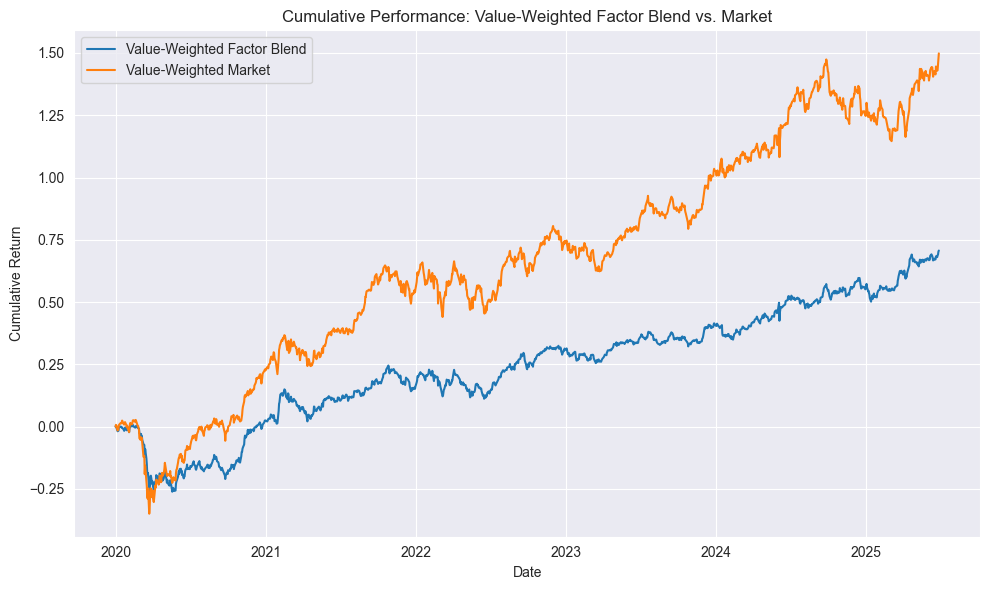

Strategy Annual Return:   10.89%
Strategy Annual Volatility: 13.95%
Strategy Sharpe Ratio:      0.78

Volatility Attribution (% of total):


,Factor,Weight,Volatility Contribution (%)
MKT,MKT,0.25,29.64
SMB,SMB,0.25,23.19
HML,HML,0.25,28.60
WML,WML,0.25,18.56



Backtest results saved to CSV files


In [19]:
# 1. Compute factor‐blend strategy P&L (long only, equal weight across MKT, SMB, HML, WML)
print("Testing simple long‐only value‐weighted factor strategy...")
factor_cols = ['MKT','SMB','HML','WML']
weights = {f: 1.0/len(factor_cols) for f in factor_cols}
strategy_ret = sum(factors_df[f] * w for f,w in weights.items())

# 2. Cumulative performance vs. market
cum_strategy = (1 + strategy_ret).cumprod() - 1
cum_mkt      = (1 + factors_df['MKT']).cumprod() - 1

plt.figure(figsize=(10,6))
plt.plot(cum_strategy, label='Value-Weighted Factor Blend')
plt.plot(cum_mkt,      label='Value-Weighted Market')
plt.title("Cumulative Performance: Value-Weighted Factor Blend vs. Market")
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.legend(); plt.tight_layout(); plt.show()

# 3. Annualized metrics
ann_ret = strategy_ret.mean()*252
ann_vol = strategy_ret.std()*np.sqrt(252)
sharpe = ann_ret/ann_vol if ann_vol else float('nan')
print(f"Strategy Annual Return:   {ann_ret*100:.2f}%")
print(f"Strategy Annual Volatility: {ann_vol*100:.2f}%")
print(f"Strategy Sharpe Ratio:      {sharpe:.2f}")

# 4. Volatility attribution
factor_rets = factors_df[factor_cols]
cov = factor_rets.cov()*252
w = np.array([weights[f] for f in factor_cols])
contrib_var = w * (cov.dot(w))
contrib_pct = contrib_var / (w.dot(cov).dot(w)) * 100

attrib_df = pd.DataFrame({
    'Factor': factor_cols,
    'Weight': list(weights.values()),
    'Volatility Contribution (%)': contrib_pct
})
print("\nVolatility Attribution (% of total):")
display(attrib_df.round(2))

# 5. Save results
cum_strategy.to_csv("backtest_cum_strategy_value_weighted.csv",
                    header=['Cumulative Return'])
strategy_ret.to_csv("backtest_daily_strategy_value_weighted.csv",
                    header=['Daily Return'])
attrib_df.to_csv("backtest_vol_attribution_value_weighted.csv",
                 index=False)
print("\nBacktest results saved to CSV files")


# Advanced Analyses and Extensions
In this final analysis cell:
- Rolling-window regressions compute time-varying factor exposures (betas) for an individual stock
- If sector mapping is provided, sector-level factor returns and betas are calculated
- Results of these advanced analyses are saved for detailed exploration

Computing rolling 1-year (252d) regressions for RELIANCE...
Rolling betas head:


,const,MRP,SMB,HML,WML
Date,,,,,
2021-01-04 00:00:00+05:30,0.000118,1.693412,-1.185424,0.359807,-0.548401
2021-01-05 00:00:00+05:30,0.000102,1.692677,-1.186835,0.361532,-0.547433
2021-01-06 00:00:00+05:30,0.000058,1.696740,-1.191326,0.359669,-0.545958
2021-01-07 00:00:00+05:30,0.000074,1.695603,-1.190185,0.359634,-0.544819
2021-01-08 00:00:00+05:30,0.000099,1.695002,-1.189608,0.359530,-0.544550


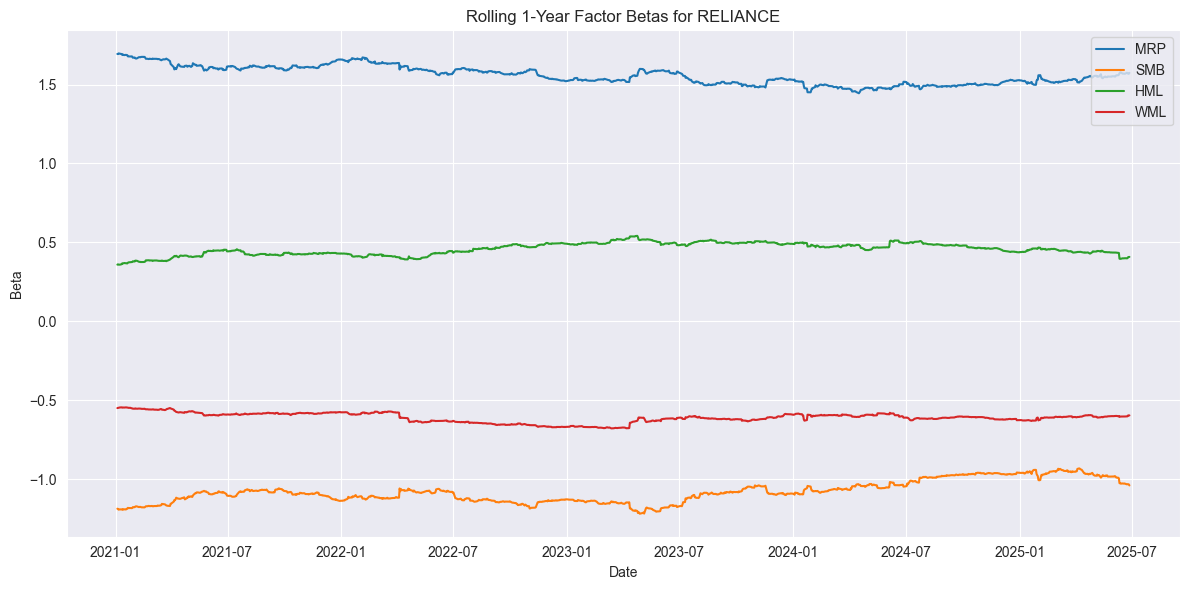


Sector returns head:


,Energy,Information Technology,Financial Services,Consumer Staples,Telecommunication Services,Materials,Industrials,Consumer Discretionary
Date,,,,,,,,
2020-01-01 00:00:00+05:30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02 00:00:00+05:30,0.017024,-0.003754,0.006843,0.004062,0.004192,-0.001422,0.026986,0.002482
2020-01-03 00:00:00+05:30,0.001205,0.017655,-0.012255,-0.005549,-0.000220,-0.021919,-0.007619,-0.010314
2020-01-06 00:00:00+05:30,-0.023192,-0.004838,-0.027713,-0.010241,-0.011975,-0.025265,-0.013707,-0.029204
2020-01-07 00:00:00+05:30,0.015385,-0.006183,0.004316,0.001902,-0.010119,0.010104,0.002848,0.004430



Sector Factor Betas:


,const,MRP,SMB,HML,WML
Energy,0.000282,1.603431,-1.118852,0.427176,-0.588170
Information Technology,-0.000078,1.376990,0.177271,-0.867573,-0.262835
Financial Services,-0.000244,0.379530,0.607862,0.539074,0.208858
Consumer Staples,-0.000116,0.559833,0.352486,-0.213191,-0.199912
Telecommunication Services,0.000508,1.571421,-0.081498,-0.944440,0.423823
Materials,-0.000230,0.831924,0.077697,-0.284101,-0.174530
Industrials,0.000142,0.573873,0.474124,0.139334,0.001581
Consumer Discretionary,-0.000189,0.742277,0.347033,-0.010777,-0.087841



 Advanced analysis results saved.


In [20]:
 # 1. Rolling Regression: time-varying betas for a chosen stock

target = "RELIANCE"  # change as needed
print(f"Computing rolling 1-year (252d) regressions for {target}...")

# Prepare aligned returns
prices = model.price_data[target]['Close'].reindex(model.factor_returns.index).fillna(method='ffill')
ret = prices.pct_change().fillna(0)
excess_ret = ret - model.factor_returns['RF']

# Build factor DataFrame
X_full = sm.add_constant(model.factor_returns[['MRP','SMB','HML','WML']])

window = 252
dates = excess_ret.index[window:]
betas = {f: [] for f in ['const','MRP','SMB','HML','WML']}
betas['Date'] = []

for i in range(window, len(excess_ret)):
    y_win = excess_ret.iloc[i-window:i]
    X_win = X_full.iloc[i-window:i]
    ols = sm.OLS(y_win, X_win).fit()
    for f in betas:
        if f != 'Date':
            betas[f].append(ols.params.get(f, 0.0))
    betas['Date'].append(excess_ret.index[i])

beta_df = pd.DataFrame(betas).set_index('Date')
print("Rolling betas head:")
display(beta_df.head())

# 2. Plot rolling betas
plt.figure(figsize=(12,6))
for f in ['MRP','SMB','HML','WML']:
    plt.plot(beta_df.index, beta_df[f], label=f)
plt.title(f"Rolling 1-Year Factor Betas for {target}")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Sector-level factor returns (if sector info available)
# Mapping of NSE tickers to their primary sectors
sector_map = {
    "RELIANCE" : "Energy",
    "TCS" : "Information Technology",
    "INFY" : "Information Technology",
    "HDFCBANK" : "Financial Services",
    "ICICIBANK" : "Financial Services",
    "KOTAKBANK" : "Financial Services",
    "SBIN" : "Financial Services",
    "BAJFINANCE" : "Financial Services",
    "HINDUNILVR" : "Consumer Staples",
    "ITC" : "Consumer Staples",
    "BHARTIARTL" : "Telecommunication Services",
    "ASIANPAINT" : "Materials",
    "LT" : "Industrials",
    "AXISBANK" : "Financial Services",
    "MARUTI" : "Consumer Discretionary"
}

# Requires a dict `sector_map = {'RELIANCE':'Energy', ...}`
try:
    sector_map  # user-defined mapping of ticker → sector
except NameError:
    print("Define `sector_map` dict mapping tickers to sectors first.")
else:
    # group stocks by sector and compute equal-weight sector return
    sectors = {}
    for sym, sec in sector_map.items():
        if sym in model.price_data:
            ret_sym = model.price_data[sym]['Close'].pct_change().reindex(model.factor_returns.index).fillna(0)
            sectors.setdefault(sec, []).append(ret_sym)
    # average across members
    sector_ret = {sec: pd.concat(rts, axis=1).mean(axis=1) for sec, rts in sectors.items()}
    sector_df = pd.DataFrame(sector_ret)
    print("\nSector returns head:")
    display(sector_df.head())

    # regress each sector return on factors
    sec_betas = {}
    for sec, series in sector_df.items():
        y = series - model.factor_returns['RF']
        X = sm.add_constant(model.factor_returns[['MRP','SMB','HML','WML']])
        ols = sm.OLS(y, X).fit()
        sec_betas[sec] = ols.params
    sec_beta_df = pd.DataFrame(sec_betas).T
    print("\nSector Factor Betas:")
    display(sec_beta_df)

# 4. Save advanced analysis outputs
beta_df.to_csv("rolling_betas_reliance.csv")
if 'sec_beta_df' in locals():
    sec_beta_df.to_csv("sector_factor_betas.csv")
print("\n Advanced analysis results saved.")
